<a href="https://colab.research.google.com/github/Urmilakoli/big-data-product-rating-prediction/blob/main/Plant_Disease_Classification_CV_AI_Urmila_koli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Purge heavy frameworks you’re not using (RAPIDS/TF/CuPy/etc.)
%pip -q uninstall -y \
  cudf-cu12 cuml-cu12 dask-cudf-cu12 dask-cuda pylibcugraph-cu12 nx-cugraph-cu12 \
  cupy-cuda12x tensorflow tensorflow-decision-forests dopamine-rl \
  stumpy pynndescent librosa shap

In [2]:
# [1.1] Check GPU
import torch, sys, platform
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch: 2.8.0+cu126
CUDA available: False


In [3]:
!pip -q install --upgrade pip
!pip -q install torchvision timm==1.0.9 albumentations==1.4.6 opencv-python==4.10.0.84 matplotlib==3.9.2 scikit-learn==1.5.2 tqdm==4.66.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires stumpy>=1.7.2, which is not installed.
umap-learn 0.5.9.post2 requires pynndescent>=0.5, which is not installed.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np, os, shutil, random, json


In [8]:
# [3B.1] Clone PlantDoc dataset
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git /content/PlantDoc-Dataset
!find /content/PlantDoc-Dataset -maxdepth 2 -type d | head -n 20



Cloning into '/content/PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 42.52 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.
/content/PlantDoc-Dataset
/content/PlantDoc-Dataset/.git
/content/PlantDoc-Dataset/.git/hooks
/content/PlantDoc-Dataset/.git/objects
/content/PlantDoc-Dataset/.git/branches
/content/PlantDoc-Dataset/.git/logs
/content/PlantDoc-Dataset/.git/refs
/content/PlantDoc-Dataset/.git/info
/content/PlantDoc-Dataset/train
/content/PlantDoc-Dataset/train/Cherry leaf
/content/PlantDoc-Dataset/train/Bell_pepper leaf spot
/content/PlantDoc-Dataset/train/Tomato Early blight leaf
/content/PlantDoc-Dataset/train/Potato leaf early blight
/content/PlantDoc-Dataset/train/Tomato leaf late blight
/content/Plan

In [9]:
# Use the path where you cloned the repo:
BASE_DIR = "/content/PlantDoc-Dataset"

# (If you used the ZIP instead, it’s usually:)
# BASE_DIR = "/content/PlantDoc-Dataset-master/PlantDoc-Dataset/PlantDoc-Dataset"


In [10]:
!find "$BASE_DIR" -maxdepth 2 -type d | head -n 20


/content/PlantDoc-Dataset
/content/PlantDoc-Dataset/.git
/content/PlantDoc-Dataset/.git/hooks
/content/PlantDoc-Dataset/.git/objects
/content/PlantDoc-Dataset/.git/branches
/content/PlantDoc-Dataset/.git/logs
/content/PlantDoc-Dataset/.git/refs
/content/PlantDoc-Dataset/.git/info
/content/PlantDoc-Dataset/train
/content/PlantDoc-Dataset/train/Cherry leaf
/content/PlantDoc-Dataset/train/Bell_pepper leaf spot
/content/PlantDoc-Dataset/train/Tomato Early blight leaf
/content/PlantDoc-Dataset/train/Potato leaf early blight
/content/PlantDoc-Dataset/train/Tomato leaf late blight
/content/PlantDoc-Dataset/train/Tomato leaf mosaic virus
/content/PlantDoc-Dataset/train/Apple leaf
/content/PlantDoc-Dataset/train/Soyabean leaf
/content/PlantDoc-Dataset/train/Corn rust leaf
/content/PlantDoc-Dataset/train/Apple rust leaf
/content/PlantDoc-Dataset/train/Tomato Septoria leaf spot


Verify images- clean

In [11]:
from PIL import Image, UnidentifiedImageError
import pathlib, tqdm as tq, os

def verify_images(root):
    bad = []
    for p in tq.tqdm(list(pathlib.Path(root).rglob("*.*"))):
        try:
            with Image.open(p) as im:
                im.verify()
        except (UnidentifiedImageError, OSError):
            bad.append(str(p))
            try:
                os.remove(p)
            except:
                pass
    return bad

bad_files = verify_images(BASE_DIR)
print("Corrupt/Unreadable removed:", len(bad_files))


100%|██████████| 2597/2597 [00:01<00:00, 2167.62it/s]

Corrupt/Unreadable removed: 18


80/10/10 split

In [12]:
from sklearn.model_selection import train_test_split
import os, glob, shutil, random, numpy as np
from pathlib import Path

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def _is_image(p: Path):
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def _collect_by_class(base: str):
    """
    Returns dict: {class_name: [list of image paths]}.
    Works for:
      (A) base/class_name/*.jpg
      (B) base/{train,val,valid,test}/class_name/*.jpg
    """
    base_p = Path(base)
    entries = [d.name for d in base_p.iterdir() if d.is_dir()]
    subset_candidates = {"train", "val", "valid", "test"}
    has_subsets = any(e.lower() in subset_candidates for e in entries)

    by_class = {}

    if not has_subsets:
        # Layout A: base/class/*.*
        for cls_dir in sorted(d for d in base_p.iterdir() if d.is_dir()):
            files = [p for p in cls_dir.glob("*") if _is_image(p)]
            if files:
                by_class[cls_dir.name] = files
    else:
        # Layout B: base/subset/class/*.*
        for subset in ("train", "val", "valid", "test"):
            subset_dir = base_p / subset
            if not subset_dir.is_dir():
                continue
            for cls_dir in sorted(d for d in subset_dir.iterdir() if d.is_dir()):
                files = [p for p in cls_dir.glob("*") if _is_image(p)]
                if files:
                    by_class.setdefault(cls_dir.name, []).extend(files)

    return by_class

def make_split(base, out="/content/plant_split", seed=42):
    random.seed(seed); np.random.seed(seed)

    by_class = _collect_by_class(base)
    classes = sorted(by_class.keys())
    if not classes:
        raise RuntimeError(f"No classes/images found under {base}")

    # Create output dirs
    for subset in ["train","val","test"]:
        for c in classes:
            os.makedirs(os.path.join(out, subset, c), exist_ok=True)

    # Split and copy
    for c in classes:
        files = by_class[c]
        files = sorted(files)  # deterministic ordering before splitting

        # Handle small classes safely
        if len(files) < 3:
            target_subset = "train" if len(files) >= 1 else None
            if target_subset:
                for f in files:
                    dst = os.path.join(out, target_subset, c, os.path.basename(f))
                    if not os.path.exists(dst):
                        shutil.copy2(str(f), dst)
            continue

        # Per-class split (no need to stratify since we split class-by-class)
        train_files, temp = train_test_split(files, test_size=0.2, random_state=seed)
        if len(temp) < 2:
            val_files, test_files = temp[:1], temp[1:]
        else:
            val_files, test_files = train_test_split(temp, test_size=0.5, random_state=seed)

        for srcs, subset in [(train_files,"train"), (val_files,"val"), (test_files,"test")]:
            for f in srcs:
                dst = os.path.join(out, subset, c, os.path.basename(f))
                if not os.path.exists(dst):
                    shutil.copy2(str(f), dst)

    return classes, out

classes, SPLIT_DIR = make_split(BASE_DIR)
print(len(classes), classes[:10])
print("Split at:", SPLIT_DIR)


28 ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf']
Split at: /content/plant_split


In [13]:
def count_images(root):
    counts = {}
    for subset in ["train","val","test"]:
        total = 0
        for c in classes:
            n = len([f for f in glob.glob(os.path.join(root, subset, c, "*")) if os.path.isfile(f)])
            total += n
        counts[subset] = total
    return counts

print(count_images(SPLIT_DIR))


{'train': 2049, 'val': 257, 'test': 271}


In [14]:
# [5.1] Transforms & datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2, math

IMG_SIZE = 224
MEAN = (0.485,0.456,0.406)
STD  = (0.229,0.224,0.225)

train_tfms = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=IMG_SIZE//10, max_width=IMG_SIZE//10, p=0.2),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

class ImageFolderA(Dataset):
    def __init__(self, root, tfm):
        self.items, self.labels, self.classes = [], [], sorted(os.listdir(root))
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for c in self.classes:
            cdir = os.path.join(root, c)
            for f in os.listdir(cdir):
                self.items.append(os.path.join(cdir, f))
                self.labels.append(self.class_to_idx[c])
        self.tfm = tfm
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i], self.labels[i]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        im = self.tfm(image=im)["image"]
        return im, y

train_ds = ImageFolderA(os.path.join(SPLIT_DIR, "train"), train_tfms)
val_ds   = ImageFolderA(os.path.join(SPLIT_DIR, "val"),   val_tfms)
test_ds  = ImageFolderA(os.path.join(SPLIT_DIR, "test"),  val_tfms)

In [15]:
# [5.2] Handle class imbalance with a WeightedRandomSampler
from collections import Counter
class_counts = Counter(train_ds.labels)
num_samples = len(train_ds)
weights = [1.0 / class_counts[y] for y in train_ds.labels]
sampler = WeightedRandomSampler(weights, num_samples=num_samples, replacement=True)

BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds), len(classes)

(2049, 257, 271, 28)

Dataset Sizes printed

Model : efficient Net-b0 (build model)

In [16]:
import timm, torch.nn as nn, torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=len(classes))
# (timm sets classifier automatically when num_classes provided)
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2


# [6.2] Freeze backbone first (optional warm-up)

In [17]:
for name, p in model.named_parameters():
    if "classifier" not in name:
        p.requires_grad = False


[6.3] Loss, optimizer, scheduler

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-1530944810.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


[7] Train (warm-up → fine-tune)

In [19]:
# [7.1] Training loop helpers
from tqdm import tqdm
def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total, correct, loss_sum = 0, 0, 0.0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)
        if train_mode:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        preds = logits.argmax(1)
        correct += (preds==y).sum().item()
        total += y.size(0)
        loss_sum += loss.item()*y.size(0)
    return loss_sum/total, correct/total

best_acc, patience, bad = 0.0, 5, 0
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}


In [20]:
# [7.2] Warm-up (train classifier only)
EPOCHS_WARM = 3
for epoch in range(1, EPOCHS_WARM+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step()
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    print(f"[WarmUp {epoch}] train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")

  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3824631537.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[WarmUp 1] train_acc=0.205 val_acc=0.300


[WarmUp 2] train_acc=0.445 val_acc=0.381


[WarmUp 3] train_acc=0.562 val_acc=0.397


In [ ]:
# [7.3] Unfreeze top layers for fine-tuning
for name, p in model.named_parameters():
    p.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1)

EPOCHS_FINE = 10
best_state = None
for epoch in range(1, EPOCHS_FINE+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step(va_loss)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    print(f"[Fine {epoch}] train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")

    if va_acc > best_acc:
        best_acc, bad, best_state = va_acc, 0, model.state_dict()
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

  0%|          | 0/33 [00:00<?, ?it/s]/tmp/ipython-input-3824631537.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Fine 1] train_acc=0.682 val_acc=0.525


 67%|██████▋   | 22/33 [06:27<03:01, 16.48s/it]

In [ ]:
# [7.1] Training loop helpers
from tqdm import tqdm
import torch
import torch.nn as nn
import os
import json
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
import timm # Import timm to define the model later

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming SPLIT_DIR is defined from the data splitting step
SPLIT_DIR = "/content/plant_split"

# [5.1] Transforms & datasets
IMG_SIZE = 224
MEAN = (0.485,0.456,0.406)
STD  = (0.229,0.224,0.225)

train_tfms = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=IMG_SIZE//10, max_width=IMG_SIZE//10, p=0.2),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

class ImageFolderA(Dataset):
    def __init__(self, root, tfm):
        self.items, self.labels, self.classes = [], [], sorted(os.listdir(root))
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for c in self.classes:
            cdir = os.path.join(root, c)
            for f in os.listdir(cdir):
                self.items.append(os.path.join(cdir, f))
                self.labels.append(self.class_to_idx[c])
        self.tfm = tfm
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i], self.labels[i]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        im = self.tfm(image=im)["image"]
        return im, y

train_ds = ImageFolderA(os.path.join(SPLIT_DIR, "train"), train_tfms)
val_ds   = ImageFolderA(os.path.join(SPLIT_DIR, "val"),   val_tfms)

# [5.2] Handle class imbalance with a WeightedRandomSampler
class_counts = Counter(train_ds.labels)
num_samples = len(train_ds)
weights = [1.0 / class_counts[y] for y in train_ds.labels]
sampler = WeightedRandomSampler(weights, num_samples=num_samples, replacement=True)

BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# [6.1] Model : efficient Net-b0 (build model)
classes = train_ds.classes # Define classes
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=len(classes))
model.to(device)

# [6.2] Freeze backbone first (optional warm-up)
for name, p in model.named_parameters():
    if "classifier" not in name:
        p.requires_grad = False

# [6.3] Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total, correct, loss_sum = 0, 0, 0.0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)
        if train_mode:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        preds = logits.argmax(1)
        correct += (preds==y).sum().item()
        total += y.size(0)
        loss_sum += loss.item()*y.size(0)
    return loss_sum/total, correct/total

best_acc, patience, bad = 0.0, 5, 0
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

# [7.2] Warm-up (train classifier only)
EPOCHS_WARM = 3
for epoch in range(1, EPOCHS_WARM+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step()
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    print(f"[WarmUp {epoch}] train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")

# [7.3] Unfreeze top layers for fine-tuning
for name, p in model.named_parameters():
    p.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1)

EPOCHS_FINE = 10
best_state = None
for epoch in range(1, EPOCHS_FINE+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step(va_loss)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    print(f"[Fine {epoch}] train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")

    if va_acc > best_acc:
        best_acc, bad, best_state = va_acc, 0, model.state_dict()
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# [7.4] Restore best
if best_state is not None:
    model.load_state_dict(best_state)

# Save artifacts
os.makedirs("/content/artifacts", exist_ok=True)
torch.save({"state_dict": model.state_dict(), "classes": classes}, "/content/artifacts/efficientnet_b0_best.pt")
with open("/content/artifacts/classes.json","w") as f: json.dump(classes, f, indent=2)

/tmp/ipython-input-3959963015.py:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3959963015.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[WarmUp 1] train_acc=0.201 val_acc=0.319


[WarmUp 2] train_acc=0.464 val_acc=0.381


[WarmUp 3] train_acc=0.538 val_acc=0.479


  0%|          | 0/33 [00:00<?, ?it/s]

Train (warm-up → fine-tune)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision 

                                      precision    recall  f1-score   support

                     Apple Scab Leaf      0.000     0.000     0.000        10
                          Apple leaf      0.500     0.200     0.286        10
                     Apple rust leaf      0.000     0.000     0.000         9
                    Bell_pepper leaf      0.000     0.000     0.000         7
               Bell_pepper leaf spot      0.050     0.125     0.071         8
                      Blueberry leaf      0.000     0.000     0.000        12
                         Cherry leaf      0.000     0.000     0.000         6
                 Corn Gray leaf spot      0.000     0.000     0.000         7
                    Corn leaf blight      0.113     0.300     0.164        20
                      Corn rust leaf      0.000     0.000     0.000        12
                          Peach leaf      0.000     0.000     0.000        12
            Potato leaf early blight      0.000     0.000     0

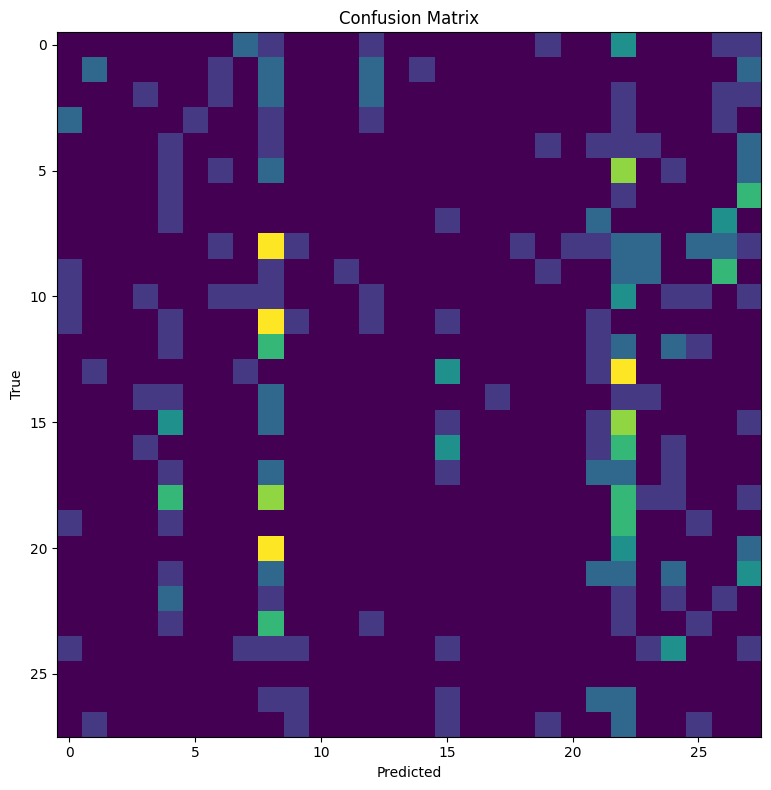

In [17]:
# [8.1] Metrics and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os # Import os module
import numpy as np # Import numpy
import timm, torch.nn as nn, torch # Import necessary modules for model
from tqdm import tqdm # Import tqdm
import matplotlib.pyplot as plt # Import matplotlib

# Redefine test_loader from the previous cell
# [5.1] Transforms & datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2, math

IMG_SIZE = 224
MEAN = (0.485,0.456,0.406)
STD  = (0.229,0.224,0.225)

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

# Assuming SPLIT_DIR is defined from the data splitting step
SPLIT_DIR = "/content/plant_split" # Re-defining SPLIT_DIR
classes = sorted(os.listdir(os.path.join(SPLIT_DIR, "train"))) # Re-defining classes

class ImageFolderA(Dataset):
    def __init__(self, root, tfm):
        self.items, self.labels, self.classes = [], [], sorted(os.listdir(root))
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for c in self.classes:
            cdir = os.path.join(root, c)
            for f in os.listdir(cdir):
                self.items.append(os.path.join(cdir, f))
                self.labels.append(self.class_to_idx[c])
        self.tfm = tfm
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i], self.labels[i]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        im = self.tfm(image=im)["image"]
        return im, y

test_ds  = ImageFolderA(os.path.join(SPLIT_DIR, "test"),  val_tfms)

# [5.2] Handle class imbalance with a WeightedRandomSampler
from collections import Counter
# Assuming BATCH and SPLIT_DIR are defined in previous executed cells
BATCH = 64
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# Define device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=len(classes))
model.to(device)


def predict_loader(loader):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(loader, leave=False):
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(1).cpu().numpy()
            y_pred.extend(pred.tolist())
            y_true.extend(y.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_loader(test_loader)
print(classification_report(y_true, y_pred, target_names=classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

[8] Evaluate + visualise

Screenshot: Grad-CAM visualization. below

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


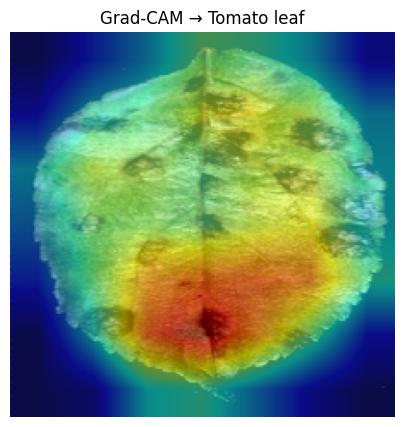

In [6]:
# [9.1] Lightweight GradCAM (works with many timm models)
!pip -q install grad-cam==1.5.5
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Define device, model, test_loader, classes, IMG_SIZE, MEAN, STD
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming SPLIT_DIR is defined from the data splitting step
SPLIT_DIR = "/content/plant_split" # Re-defining SPLIT_DIR
classes = sorted(os.listdir(os.path.join(SPLIT_DIR, "train"))) # Re-defining classes
IMG_SIZE = 224
MEAN = (0.485,0.456,0.406)
STD  = (0.229,0.224,0.225)

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

class ImageFolderA(Dataset):
    def __init__(self, root, tfm):
        self.items, self.labels, self.classes = [], [], sorted(os.listdir(root))
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for c in self.classes:
            cdir = os.path.join(root, c)
            for f in os.listdir(cdir):
                self.items.append(os.path.join(cdir, f))
                self.labels.append(self.class_to_idx[c])
        self.tfm = tfm
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i], self.labels[i]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        im = self.tfm(image=im)["image"]
        return im, y

test_ds  = ImageFolderA(os.path.join(SPLIT_DIR, "test"),  val_tfms)

BATCH = 64
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=len(classes))
model.to(device)


target_layers = [model.get_submodule("conv_head")] if hasattr(model, "conv_head") else [list(model.children())[-2]]
cam = GradCAM(model=model, target_layers=target_layers)

# Take one test image
x,y = next(iter(test_loader))
img = x[0:1].to(device)
pred = model(img).argmax(1).item()
grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(pred)])[0]
rgb = (x[0].permute(1,2,0).numpy()*STD + MEAN).clip(0,1)
vis = show_cam_on_image(rgb.astype(np.float32), grayscale_cam, use_rgb=True)
plt.figure(figsize=(5,5)); plt.imshow(vis); plt.axis('off'); plt.title(f"Grad-CAM → {classes[pred]}"); plt.show()